---
title: Fig. 3 - Calculate Spectral Tree
author: Benjamin Doran
date: today
---

In [1]:
#| code-fold: true
#| code-summary: julia setup
#| output: false
using DrWatson
@quickactivate projectdir()

using SpectralInference
using NeighborJoining
using NewickTree
using Muon, CSV, DataFrames
using StatsBase
using Random: seed!
using StatsPlots
using Gotree_jll
theme(:default, grid=false, label=false, tickdir=:out)
include(srcdir("helpers.jl"))


import CondaPkg
CondaPkg.activate!(ENV)
using RCall
@show readlines(`which R`)
R"""
library(ape)
library(treeio)
library(ggtree)
library(ggplot2)
library(tidyverse)
library(tidytree)

setwd($(projectdir()))
""";


ddir = datadir("exp_raw", "UP7047")
micurvedir = datadir("exp_pro", "UP7047") |> mkpath
pdir_tree = plotsdir("UP7047_treeplots") |> mkpath
pdir_micurve = plotsdir("UP7047_curve") |> mkpath;

    CondaPkg Found dependencies: /Users/bend/projects/Doran_etal_2023/CondaPkg.toml
    CondaPkg Found dependencies: /Users/bend/.julia/environments/v1.10/CondaPkg.toml
    CondaPkg Found dependencies: /Users/bend/.julia/packages/PythonCall/Nr75f/CondaPkg.toml
    CondaPkg Dependencies already up to date


readlines(`which R`) = ["/Users/bend/projects/Doran_etal_2023/.CondaPkg/env/bin/R"]


┌ Warning: RCall.jl: treeio v1.27.0.002 For help: https://yulab-smu.top/treedata-book/
│ 
│ If you use the ggtree package suite in published research, please cite
│ the appropriate paper(s):
│ 
│ LG Wang, TTY Lam, S Xu, Z Dai, L Zhou, T Feng, P Guo, CW Dunn, BR
│ Jones, T Bradley, H Zhu, Y Guan, Y Jiang, G Yu. treeio: an R package
│ for phylogenetic tree input and output with richly annotated and
│ associated data. Molecular Biology and Evolution. 2020, 37(2):599-603.
│ doi: 10.1093/molbev/msz240
│ 
│ S Xu, Z Dai, P Guo, X Fu, S Liu, L Zhou, W Tang, T Feng, M Chen, L
│ Zhan, T Wu, E Hu, Y Jiang, X Bo, G Yu. ggtreeExtra: Compact
│ visualization of richly annotated phylogenetic data. Molecular Biology
│ and Evolution. 2021, 38(9):4039-4042. doi: 10.1093/molbev/msab166
│ 
│ Guangchuang Yu. Using ggtree to visualize data on tree-like structures.
│ Current Protocols in Bioinformatics. 2020, 69:e96. doi:10.1002/cpbi.96
└ @ RCall /Users/bend/.julia/packages/RCall/0ggIQ/src/io.jl:172
┌ Warning

# Main - Spectral Tree of 7047 strains from UniProt

We had the hypothesis that by leveraging the vast diversity of sequenced strains procured from many different environments, we could ‘fill in’ evolutionary distance within our strain bank in
a more complete way.

To test this hypothesis, we used the 7047 bacterial proteomes within UniProt's '2020_02' release as our reference, as it contained strains collected across ocean, soil, human and mouse microbiomes, amongst other environments.

In [2]:
# read data
uniprot = readh5ad(datadir("exp_raw", "UP7047", "2020_02_UP7047.h5ad"))

AnnData object 7047 ✕ 10177

In [3]:
# what's the matrix look like
# 7047 bacterial strains x 10177 orthologs 
# each element is the number of sequences in the strain that map to that ortholog (emapper v2)
upmtx = uniprot.X[:, :]

7047×10177 Matrix{Float64}:
 1.0  0.0  1.0  2.0  1.0  3.0  2.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  1.0  2.0  0.0  2.0  2.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  1.0  3.0  1.0  2.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  1.0  2.0  0.0  1.0  2.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  1.0  2.0  1.0  2.0  2.0  1.0  …  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 6.0  2.0  1.0  3.0  1.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  2.0  2.0  0.0  0.0  2.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 2.0  3.0  1.0  2.0  1.0  2.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱  ⋮                        ⋮    
 1.0  0.0  1.0  5.0  0.0  3.0  2.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 3.0  0.0  1.0  2.0  1.0  1.0  2.0  0.0

In [4]:
# spectrally decompose matrix with SVD
@time usv = svd(upmtx);

100.248192 seconds (336 allocations: 2.550 GiB, 0.11% gc time, 0.01% compilation time)


## Calculating the SPI distance matrix

The next step is to compute the spectral distance matrices. There are a few ways of calling this function.

SpectralInference relies on two conceptual parts, how we partition the spectrum and how we compute the distance within that partition.

Thus, there are two main functions in SpectralInferences

```julia
getintervals(singularvalues)
```

and 

```julia
spectraldistances()
```

This is the entirety of `spectraldistances()`

```julia
function spectraldistances(vecs::AbstractMatrix{<:T}, vals::AbstractVector{<:T}, intervals::AbstractVector) where {T<:Number}
    spimtx = zeros(size(vecs, 1), size(vecs, 1))
    for grp in intervals
        spimtx += Distances.pairwise(WeightedEuclidean(vals[grp]), vecs'[grp, :]; dims=2)
    end
    return spimtx .^ 2
end
```

There are a few different ways to call the `spectraldistances()` function.

We could just provide the full SVD object
`dij = spectraldistances(usv)`
by default this will compute the row-wise distances.

We could specify that we want the column-wise distances by providing the full SVD object and an option to dispatch on the `V` matrix

```julia
dij = spectraldistances(usv, onrows=false) # will compute the colwise distances
```

Alternatively we can explicitly provide the vectors and values to the function. Along with a vector of Ranges that specify how to split the spectrum. 

First we compute and plot our partitions

In [9]:
partitions = getintervals(usv.S, alpha=1.5, q=.75);
size(partitions)

(880,)

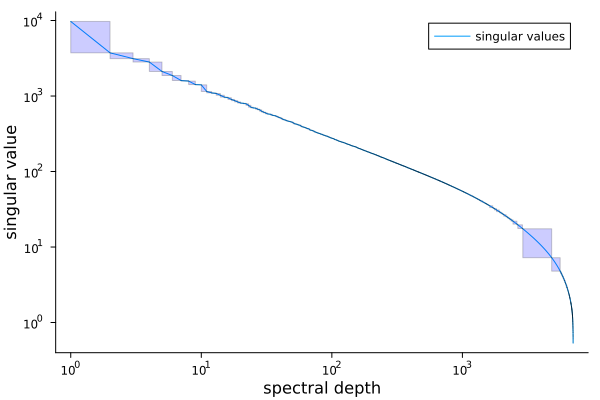

In [47]:
rectangle(x, y, w, h) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])
plot(
    xlabel="spectral depth",
    ylabel="singular value",
    ticks=[exp10(i) for i in 0:4],
    scale=:log10, 
)
plot!(usv.S, label="singular values")

pltpars = @. rectangle(
    first(partitions[1:end-1]), # x
    usv.S[first(partitions[1:end-1])], # y
    length(partitions[1:end-1]), # width
    usv.S[first(partitions[2:end])] - usv.S[first(partitions[1:end-1])] # height
)
plot!(pltpars, c=:blue, alpha=.2)


Then we compute the spectral distances using these partitions

In [48]:
@time dij = spectraldistances(usv.U, usv.S, partitions);

243.653901 seconds (639.25 k allocations: 652.763 GiB, 46.67% gc time, 0.05% compilation time: 100% of which was recompilation)


## calculate a tree from the SPI distance matrix. 

So far I have been using basic hierarchical clustering functions; however, basic hierarchical clustering assumes a constant rate of evolution and because this is a dataset of natural systems (i.e. bacteria across natural evolution), this core assumption is likely broken. Thus we will use neighbor joining to compute our Spectral Tree.

We can calculate the tree as so...

In [54]:
@time basetreestring = NeighborJoining.newickstring(fastNJ(dij), uniprot.obs_names)

  7.771650 seconds (80.46 k allocations: 4.352 GiB, 2.59% gc time)


"((((((((((UP000196862:3.792218e+03,UP000196784:2.725449e+03):1.317085e+02,((((((((UP000000495:7.179702e+03,UP000031552:4.580198e+03):8.581783e+02,UP000220251:3.746455e+03):7.454054e+02,UP000001505:5.245389e+03):5.237153e+02,(UP000000529:8.451443e+03,UP000069902:4.70780" ⋯ 281327 bytes ⋯ "2.996011e+03,UP000003178:5.527377e+03):2.793630e+03):1.583835e+03):9.098764e+02,((UP000264006:2.827825e+04,UP000291469:1.076784e+04):4.983053e+03,UP000268521:1.497309e+04):1.851582e+03):8.505975e+02):2.649550e+02):9.907906e+01):3.808693e+01):1.322603e+01):0.000000e+00;"

In [59]:
# write out tree
UP7047_treedir = projectdir("_research", "UP7047_neighborjoined_spitree") |> mkpath
open(joinpath(UP7047_treedir, "2020_02_UP7047-tree.nw"), "w") do io
    println(io, basetreestring)
end

So far we have compute the reference SPI tree, we may also want some measure of how statistically confident we are on each of the branches and merges we have predicted in the tree. That is best performed through a boot strap analysis. Where we sample with replacement the features and recompute the SPI distance matrix and tree.

In [127]:
using Distributed
rmprocs(workers()) # remove any current workers
addprocs() # startup default number (8) workers 
@everywhere using DrWatson
@everywhere @quickactivate projectdir()
@everywhere using SpectralInference
@everywhere using NeighborJoining
@everywhere using Muon
@everywhere uniprot = readh5ad(datadir("exp_raw", "UP7047", "2020_02_UP7047.h5ad"))
@everywhere upmtx = uniprot.X[:,:]
@everywhere upids = uniprot.obs_names
@everywhere function runbootstrap(feature_ids, mtx=upmtx, ids=upids)
    M = mtx[:, feature_ids] #  matrix bootstrapped on columns
    vals, vecs = eigen(Matrix(M * M')) # more efficient than SVD as it only computes the row-wise factorization
    # floating point impercision gives some -1e-16 vals so set them to zero
    # and take the square root to get singular values rather than eigen values
    S = sqrt.(max.(vals, zero(eltype(vals)))) 
    dij = spectraldistances(vecs, S; alpha=1.5, q=.75) # use same params as reference tree
    treestring = NeighborJoining.newickstring(fastNJ(dij), ids) # get tree string
end

In [128]:
nworkers()

8

In [129]:
# generate 100 bootstraps
nboot = 100
Nfeatures = size(upmtx, 2)
seed!(123456)
feature_bootstraps = map(1:nboot) do _
    sample(1:Nfeatures, Nfeatures, replace=true) 
end;

In [134]:
# takes about 90 min
# runs bootstrap
@time boottreestrings = pmap(runbootstrap, feature_bootstraps);

5559.022621 seconds (118.23 k allocations: 33.946 MiB)


In [135]:
boottreestrings

100-element Vector{String}:
 "((((((((((((((((((((UP0000952" ⋯ 281807 bytes ⋯ "):4.704598e+00):0.000000e+00;"
 "(((((((((((((((UP000249596:2." ⋯ 281807 bytes ⋯ "):6.561459e+00):0.000000e+00;"
 "(((((((((((((UP000266328:1.68" ⋯ 281807 bytes ⋯ "):1.261691e+01):0.000000e+00;"
 "(((((((((UP000316124:5.299888" ⋯ 281807 bytes ⋯ "):8.761738e-01):0.000000e+00;"
 "(((((((((((((((((((((((UP0000" ⋯ 281807 bytes ⋯ "):1.281320e+01):0.000000e+00;"
 "(((((((((((((((((UP000275394:" ⋯ 281807 bytes ⋯ "):2.550188e+01):0.000000e+00;"
 "((((((((((((((UP000018766:3.8" ⋯ 281807 bytes ⋯ "):6.590331e+00):0.000000e+00;"
 "((((((((((((((((((((((UP00025" ⋯ 281807 bytes ⋯ "):6.534613e+00):0.000000e+00;"
 "((((((((((((UP000191049:4.271" ⋯ 281807 bytes ⋯ "):5.556637e+00):0.000000e+00;"
 "((((((((((((((((((((((UP00031" ⋯ 281807 bytes ⋯ "):3.365659e+00):0.000000e+00;"
 ⋮
 "(((((((((((((((((((UP00007684" ⋯ 281807 bytes ⋯ "):4.705287e+00):0.000000e+00;"
 "((((((((((((UP000236317:4.054" ⋯ 281807 bytes ⋯ "):2.269391e+01):

In [137]:
rmprocs(workers())

Task (done) @0x00000002bce7b3a0

In [138]:
open(joinpath(UP7047_treedir, "2020_02_UP7047-boottrees.nw"), "w") do io
    for bt in boottreestrings
        println(io, bt)
    end
end

In [143]:
## calculate support
run(pipeline(`$(gotree()) compute support tbe --silent \
    -i $(joinpath(UP7047_treedir, "2020_02_UP7047-tree.nw")) \
    -b $(joinpath(UP7047_treedir, "2020_02_UP7047-boottrees.nw")) \
    -o $(joinpath(UP7047_treedir, "2020_02_UP7047-supporttree.nw"))`,
    stderr=joinpath(UP7047_treedir, "booster.log")))

Process(setenv(`/Users/bend/.julia/artifacts/eb6a28aa115909e9dbf2104f3bf288c51b34f308/bin/gotree compute support tbe --silent -i /Users/bend/projects/Doran_etal_2023/_research/UP7047_neighborjoined_spitree/2020_02_UP7047-tree.nw -b /Users/bend/projects/Doran_etal_2023/_research/UP7047_neighborjoined_spitree/2020_02_UP7047-boottrees.nw -o /Users/bend/projects/Doran_etal_2023/_research/UP7047_neighborjoined_spitree/2020_02_UP7047-supporttree.nw`,["XPC_FLAGS=0x0", "PATH=/Users/bend/.julia/artifacts/eb6a28aa115909e9dbf2104f3bf288c51b34f308/bin:/Users/bend/.sdkman/candidates/java/current/bin:/Users/bend/micromamba/condabin:/Users/bend/.juliaup/bin:/Users/bend/bin:/opt/homebrew/bin:/opt/homebrew/sbin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/appleinternal/b

In [147]:
tree = readnw(open(readline, joinpath(UP7047_treedir, "2020_02_UP7047-supporttree.nw")));

In [150]:
# 50% majority tree
tree_50pct = as_polytomy(n->NewickTree.support(n)<.5, tree);

In [154]:
open(joinpath(UP7047_treedir, "2020_02_UP7047-supporttree_50pct.nw"), "w") do io
    writenw(io, tree_50pct)
end

266996

## Plot UniProt tree

In [160]:
R"""
updir = file.path(getwd(), "data", "exp_raw", "UP7047")
uptreedir = file.path(getwd(), "_research", "UP7047_neighborjoined_spitree")
uniprot_spitree = read.newick(file.path(uptreedir, "2020_02_UP7047-supporttree_50pct.nw"), node.label='support')
uplineage = read.csv(file.path(updir, "UProwmeta.csv"))
uplineage$label = uplineage$Proteome_ID

biggerphyla  = sort(table(uplineage$Phylum), decreasing = TRUE)[sort(table(uplineage$Phylum), decreasing = TRUE) > 100]
bigPhylum = uplineage$Phylum
bigPhylum[!(bigPhylum %in% names(biggerphyla))] = "Misc. (# < 100)"
uplineage$bigPhylum = bigPhylum

uniprot_spitree_withdata = as.treedata(left_join(as_tibble(uniprot_spitree), uplineage, by='label'))
utree_tbl = as_tibble(uniprot_spitree_withdata)

mode_phylum = offspring(utree_tbl, utree_tbl$node, tiponly = FALSE, self_include = TRUE)
mode_phylum = unlist(lapply(mode_phylum, function(x) modeest::mfv1(x$bigPhylum, na_rm=TRUE)))

utree_tbl$mode_phylum = mode_phylum
uniprot_spitree_withdata = as.treedata(utree_tbl)
options(repr.plot.width=15, repr.plot.height=15, ignore.negative.edge=TRUE)
colorvalues = c("grey", RColorBrewer::brewer.pal(6, name="Accent"), "grey")
ggtree(uniprot_spitree_withdata, 
    aes(color=mode_phylum), 
    layout="fan", open.angle=10,
    branch.length="none",
    )  %>% rotate_tree(-240) +
    ggtitle("UniProt Spectral Tree (Neighbor Joining)") + 
    scale_color_manual(values=colorvalues, breaks=c("Misc. (# < 100)", names(biggerphyla), "unknown")) #+theme(legend.position="none")
ggsave(file.path($pdir_tree, "UniProt_SPItree_coloredbyPhylum.svg"), 
    height=7,
    width=7,
)
"""
show_svg(joinpath(pdir_tree, "UniProt_SPItree_coloredbyPhylum.svg"))

┌ Warning: RCall.jl: Scale for y is already present.
│ Adding another scale for y, which will replace the existing scale.
│ Coordinate system already present. Adding new coordinate system, which will
│ replace the existing one.
└ @ RCall /Users/bend/.julia/packages/RCall/YrsKg/src/io.jl:172


## Sub-clades of Spectral Tree

Look at local surrounding of a few taxa, they are with known closely taxonomically related neighbors

In [174]:
nthparent(n, i) = i < 1 ? n : nthparent(parent(n), i-1)

nthparent (generic function with 1 method)

In [182]:
rename_treeleaves!(tree, idmapping) = begin
    for node in getleaves(tree)
        NewickTree.setname!(node, idmapping[name(node)])
    end
    tree
end

rename_treeleaves! (generic function with 1 method)

In [204]:
uptree_leaves = getleaves(tree_50pct);

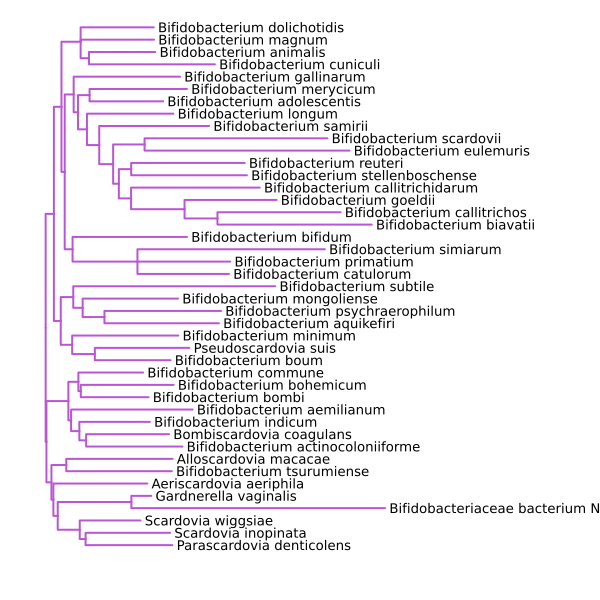

In [205]:
targetspecies = "Bifidobacterium longum"
targetid = uniprot.obs.proteomeID[uniprot.obs.Species .== targetspecies][1]
basenode = uptree_leaves[findfirst(n->name(n) == targetid, uptree_leaves)]
subtree = readnw(nwstr(nthparent(basenode, 7)))
idmapping = Dict(k=>v for (k,v) in zip(getleafnames(subtree), uniprot.obs.Species[indexin(getleafnames(subtree), uniprot.obs.proteomeID)]))
rename_treeleaves!(subtree, idmapping)
plot(subtree,
    c=:mediumorchid,
    lw=2,
    size=(600,600),
    rightmargin=5Plots.cm,
)

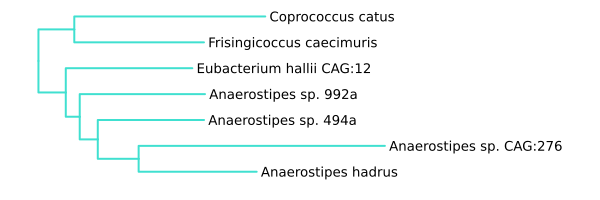

In [209]:
targetspecies = "Anaerostipes hadrus"
targetid = uniprot.obs.proteomeID[uniprot.obs.Species .== targetspecies][1]
basenode = uptree_leaves[findfirst(n->name(n) == targetid, uptree_leaves)]
subtree = readnw(nwstr(nthparent(basenode, 5)))
idmapping = Dict(k=>v for (k,v) in zip(getleafnames(subtree), uniprot.obs.Species[indexin(getleafnames(subtree), uniprot.obs.proteomeID)]))
rename_treeleaves!(subtree, idmapping)
plot(subtree,
    c=:turquoise,
    lw=2,
    size=(600,200),
    rightmargin=5Plots.cm,
)

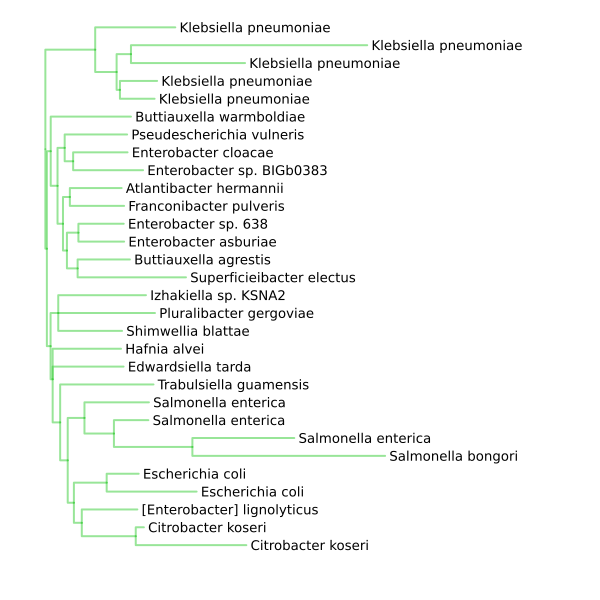

In [214]:
targetspecies = "Escherichia coli"
targetid = uniprot.obs.proteomeID[uniprot.obs.Species .== targetspecies][1]
basenode = uptree_leaves[findfirst(n->name(n) == targetid, uptree_leaves)]
subtree = readnw(nwstr(nthparent(basenode, 8)))
idmapping = Dict(k=>v for (k,v) in zip(getleafnames(subtree), uniprot.obs.Species[indexin(getleafnames(subtree), uniprot.obs.proteomeID)]))
rename_treeleaves!(subtree, idmapping)
plot(subtree,
    c=:limegreen,
    lw=2, alpha=.5,
    size=(600,600),
    rightmargin=5Plots.cm,
)

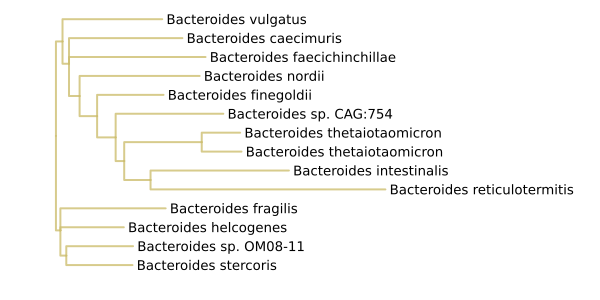

In [218]:
targetspecies = "Bacteroides fragilis"
targetid = uniprot.obs.proteomeID[uniprot.obs.Species .== targetspecies][1]
basenode = uptree_leaves[findfirst(n->name(n) == targetid, uptree_leaves)]
subtree = readnw(nwstr(nthparent(basenode, 2)))
idmapping = Dict(k=>v for (k,v) in zip(getleafnames(subtree), uniprot.obs.Species[indexin(getleafnames(subtree), uniprot.obs.proteomeID)]))
rename_treeleaves!(subtree, idmapping)
plot(subtree,
    c=:lightgoldenrod3,
    lw=2, alpha=.8,
    size=(600,300),
    rightmargin=5Plots.cm,
)

## Mutual Information across tree

To verify that our tree is systematically capturing known phylogeny we compare the grouping of the tree at varying distances from the 'root' to known NCBI taxonomic groupings and calculate the mutual information.

In [243]:
NBOOTS = 50
colnames = [:Phylum, :Class, :Order, :Family, :Genus, :Species];
UP_NCBI_taxonomy = uniprot.obs[:, colnames]
obs_names = uniprot.obs_names.vals
rowmask = map(eachrow(UP_NCBI_taxonomy)) do row
    !any(==(""), row)
end;

In [ ]:
# took 5 hours
mi_results = map(1:NBOOTS) do i
	pairedMI_across_treedepth(eachcol(UP_NCBI_taxonomy), obs_names, tree_50pct; mask=rowmask, bootstrap=true, ncuts=100, treecut_distancefun=network_distance)
end;

mi_results_df = DataFrame()
for (i, res) in enumerate(mi_results)
    mi_results_df = vcat(
        mi_results_df, 
        hcat(
            DataFrame(bootstrap=i, treedepth=last(res)),
            DataFrame(first(res), colnames),
            DataFrame(scaledcumsum.(first(res)), string.(colnames) .* "_scaledcumsum"),
        )
    )
end
CSV.write(joinpath(micurvedir, "NCBI_raw_MI_values_.csv"), mi_results_df);

In [245]:
mi_results_df = CSV.read(joinpath(micurvedir, "NCBI_raw_MI_values_.csv"), DataFrame)
mi_results_df

5000×14 DataFrame
  Row │ bootstrap  treedepth  Phylum      Class       Order        Family      ⋯
      │ Int64      Float64    Float64     Float64     Float64      Float64     ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │         1   0.0       0.0         0.0         0.0          0.0         ⋯
    2 │         1   0.282828  0.00185327  0.00140159  0.000664909  0.000378137
    3 │         1   0.565657  0.00183853  0.00139375  0.000663027  0.00038003
    4 │         1   0.848485  0.00185611  0.00140952  0.000645396  0.000391592
    5 │         1   1.13131   0.0945947   0.04664     0.0161751    0.00785406  ⋯
    6 │         1   1.41414   0.0944801   0.0465577   0.0161665    0.00785363
    7 │         1   1.69697   0.0944517   0.0465807   0.0161591    0.00785219
    8 │         1   1.9798    0.0945355   0.0465879   0.0161638    0.00785501
  ⋮   │     ⋮          ⋮          ⋮           ⋮            ⋮            ⋮      ⋱
 4994 │        50  26.303     9.51392e-7  1.52466e-6  2.35143e-6   2.71494e-6  ⋯
 4995 │        50  26.5859    8.04667e-7  1.29055e-6  2.71392e-6   3.62337e-6
 4996 │        50  26.8687    8.78081e-7  1.40809e-6  2.35273e-6   2.26313e-6
 4997 │        50  27.1515    5.1237e-7   5.86399e-7  7.23816e-7   4.52456e-7
 4998 │        50  27.4343    2.19636e-7  9.38617e-7  1.44694e-6   1.13083e-6  ⋯
 4999 │        50  27.7172    2.92639e-7  1.17321e-6  7.23742e-7   6.79435e-7
 5000 │        50  28.0       0.0         0.0         0.0          0.0
                                                 8 columns and 4985 rows omitted

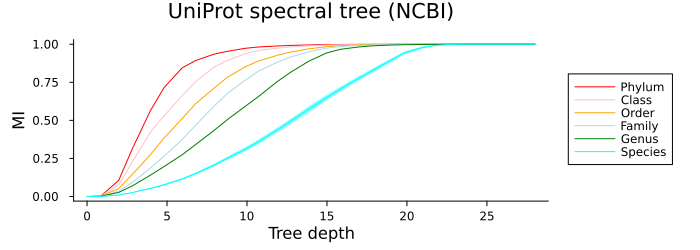

In [246]:
#| fig-cap: we see that as we move from the root to the leaves we get spiking information related Phylum, Class, Order, Family, Genus, and Species in discrete layers and in that order.
pltdf = mi_results_df |>
    df -> stack(df, 9:14, [:bootstrap, :treedepth]) |> 
    df -> transform(df, :variable => ByRow(x->replace(x, "_scaledcumsum"=>"")) => identity) |>
    df -> groupby(df, [:variable, :treedepth]) |>
    df -> combine(df,
        :value => mean => :MI_mean,
        :value => std => :MI_std,
    ) |> 
    df -> sort(df, [])
taxonomylevels = permutedims(string.(colnames))
taxarankcolors = [:red :pink :orange :lightblue :green :aqua];
plot(title="UniProt spectral tree (NCBI)", ylabel="MI", xlabel="Tree depth",
    legend=:outerright,
    size=(700,250),
    margin=5Plots.mm,  
)
for (tlab, tcol) in collect(zip(taxonomylevels, taxarankcolors))
    df = filter(:variable => ==(tlab), pltdf)
    @df df plot!(:treedepth, :MI_mean, ribbon=2 .* :MI_std, label=tlab, c=tcol, lw=1)
end
plot!()

# Fig. S6 - Plot GTDB taxonomy on Spectral Tree

Due to size constraints from github, I can't show the images embedded into the notebook, but here is the code
to make the tree plots from Figure S5.

In [2]:
using TreePlots, Chain, DataFramesMeta

function removedistances!(tree)
    function walk(node)
        if !isroot(node)
            NewickTree.setdistance!(node, 1.)
        end
        if !isleaf(node)
            walk.(children(node))
        end
        node
    end
    walk(tree)
end
function removedistances(tree)
    mytree = deepcopy(tree)
    removedistances!(mytree)
end

pdir = plotsdir("uniprot_tree") |> mkpath

"/Users/bend/projects/Doran_etal_2023/plots/uniprot_tree"

## Read in data

In [3]:
uptree = readnw(readline(projectdir("_research","UP7047_neighborjoined_spitree","2020_02_UP7047-supporttree_50pct.nw")));
SpectralInference.ladderize!(uptree)

7047

In [4]:
uniprot = readh5ad(datadir("exp_raw","UP7047","2020_02_UP7047.h5ad"))

AnnData object 7047 ✕ 10177

In [34]:
gtdbmeta = CSV.read(readdir(datadir("exp_raw", "UP7047", "bac120_metadata_r220"), join=true), DataFrame, delim="\t");
gtdbmeta_idmap = select(gtdbmeta, :accession, :gtdb_taxonomy, :ncbi_organism_name, :ncbi_species_taxid, :ncbi_taxid, :ncbi_taxonomy);
gtdbmeta_filt = gtdbmeta_idmap[filter(!isnothing, indexin(uniprot.obs.TaxID, gtdbmeta_idmap.ncbi_taxid)), :]
taxalevels = ["domain", "phylum", "class", "order", "family", "genus", "species"]
uniprotobs_gtdb_ncbi = @chain gtdbmeta_filt begin
    transform(:gtdb_taxonomy => ByRow(x->split(x, ";")) => "gtdb_" .* taxalevels)
    transform(:ncbi_taxonomy => ByRow(x->split(x, ";")) => "ncbi_" .* taxalevels)
    leftjoin(uniprot.obs, _, on = :TaxID => :ncbi_taxid)
    _[indexin(uniprot.obs.proteomeID, _.proteomeID), :]
end
CSV.write(datadir("exp_raw", "UP7047", "obs_meta_gtdb_and_ncbi.csv"), uniprotobs_gtdb_ncbi)

"/Users/bend/projects/Doran_etal_2023/data/exp_raw/UP7047/obs_meta_gtdb_and_ncbi.csv"

In [35]:
uniprotobs_gtdb_ncbi = CSV.read(datadir("exp_raw", "UP7047", "obs_meta_gtdb_and_ncbi.csv"), DataFrame);

In [36]:
nleaves = length(getleaves(uptree))
openangle = deg2rad(5)
toangle(y) = (y / (nleaves)) * (2π - (openangle % 2pi))
function xy2circ(x, y)
    R, θ = x, toangle(y)
    R*cos(θ), R*sin(θ)
end

xy2circ (generic function with 1 method)

In [37]:
gtdb_phylum_countmap = @chain uniprotobs_gtdb_ncbi.gtdb_phylum begin 
    countmap
    sort(byvalue=true, rev=true)
    filter(x->last(x) >= 100, _)
    filter(x->!ismissing(first(x)), _)
end

OrderedCollections.OrderedDict{Union{Missing, String31}, Int64} with 8 entries:
  String31("p__Pseudomonadota")   => 2331
  String31("p__Actinomycetota")   => 1278
  String31("p__Bacteroidota")     => 774
  String31("p__Bacillota")        => 676
  String31("p__Bacillota_A")      => 627
  String31("p__Bacillota_I")      => 181
  String31("p__Cyanobacteriota")  => 128
  String31("p__Desulfobacterota") => 103

In [38]:
gtdb_phylum_colordict = Dict(zip(keys(gtdb_phylum_countmap), palette(:Dark2_8, length(gtdb_phylum_countmap))))

Dict{Union{Missing, String31}, Any} with 8 entries:
  String31("p__Bacillota_I")      => RGB{Float64}(0.902,0.671,0.008)
  String31("p__Bacillota")        => RGB{Float64}(0.906,0.161,0.541)
  String31("p__Pseudomonadota")   => RGB{Float64}(0.106,0.62,0.467)
  String31("p__Bacteroidota")     => RGB{Float64}(0.459,0.439,0.702)
  String31("p__Actinomycetota")   => RGB{Float64}(0.851,0.373,0.008)
  String31("p__Bacillota_A")      => RGB{Float64}(0.4,0.651,0.118)
  String31("p__Desulfobacterota") => RGB{Float64}(0.4,0.4,0.4)
  String31("p__Cyanobacteriota")  => RGB{Float64}(0.651,0.463,0.114)

In [39]:
palette(:Dark2_8, length(gtdb_phylum_countmap))

## Plot Uniprot Spectral Tree with GTDB

In [40]:
cladedict = TreePlots.nodepositions(uptree, layoutstyle=:cladogram)
TreePlots.extend_tips!(cladedict)
segs = @chain cladedict begin
    TreePlots.makesegments(uptree)
    reduce(vcat, _)
    map((x) -> xy2circ(x...), _)
end

branchcolors = @chain uptree begin
    prewalk
    map(_) do node
        leafnames = getleafnames(node)
        idxs = indexin(leafnames, uniprotobs_gtdb_ncbi.proteomeID)
        get(gtdb_phylum_colordict, mode(uniprotobs_gtdb_ncbi.gtdb_phylum[idxs]), :lightgrey)
    end
    repeat(inner=28)
    _[2:end]
end;

In [ ]:
plot(
    size=(700, 700), 
    framestyle=:none,
    background=:transparent,
    format=:png,
    dpi=600,
    margin=-5Plots.mm,
)
plot!(segs, linewidth=2, c=branchcolors)

In [ ]:
savefig(joinpath(pdir, "uniprot_spectral_tree_colored_by_gtdb_rasterized.png"))

In [15]:
gtdb_phylum_colordict

Dict{Union{Missing, String31}, Any} with 8 entries:
  String31("p__Bacillota_I")      => RGB{Float64}(0.902,0.671,0.008)
  String31("p__Bacillota")        => RGB{Float64}(0.906,0.161,0.541)
  String31("p__Pseudomonadota")   => RGB{Float64}(0.106,0.62,0.467)
  String31("p__Bacteroidota")     => RGB{Float64}(0.459,0.439,0.702)
  String31("p__Actinomycetota")   => RGB{Float64}(0.851,0.373,0.008)
  String31("p__Bacillota_A")      => RGB{Float64}(0.4,0.651,0.118)
  String31("p__Desulfobacterota") => RGB{Float64}(0.4,0.4,0.4)
  String31("p__Cyanobacteriota")  => RGB{Float64}(0.651,0.463,0.114)

In [ ]:
branchcolors_gtdb_protobacteria = @chain uptree begin
    prewalk
    map(_) do node
        leafnames = getleafnames(node)
        idxs = indexin(leafnames, uniprotobs_gtdb_ncbi.proteomeID)
        common_phyla = coalesce(mode(uniprotobs_gtdb_ncbi.gtdb_phylum[idxs]), "")
        if common_phyla == "p__Pseudomonadota"
            gtdb_phylum_colordict["p__Pseudomonadota"]
        elseif common_phyla == "p__Desulfobacterota"
            gtdb_phylum_colordict["p__Desulfobacterota"]
        else
            :lightgray
        end
    end
    repeat(inner=28)
    _[2:end]
end;

plot(
    size=(700, 700), 
    framestyle=:none,
    background=:transparent,
    format=:png,
    dpi=600,
    margin=-5Plots.mm,
)
plot!(segs, linewidth=2, c=branchcolors_gtdb_protobacteria)

In [22]:
savefig(joinpath(pdir, "uniprot_spectral_tree_colored_by_gtdb_protobacteria_rasterized.png"))

"/Users/bend/projects/Doran_etal_2023/plots/uniprot_tree/uniprot_spectral_tree_colored_by_gtdb_protobacteria_rasterized.png"

In [17]:
@chain begin
    uniprot.obs.Phylum
    countmap
    sort(byvalue=true, rev=true)
end

OrderedCollections.OrderedDict{String, Int64} with 53 entries:
  "Proteobacteria"              => 2643
  "Firmicutes"                  => 1517
  "Actinobacteria"              => 1330
  "Bacteroidetes"               => 761
  "Cyanobacteria"               => 134
  "Tenericutes"                 => 120
  "Planctomycetes"              => 90
  ""                            => 84
  "Spirochaetes"                => 46
  "Verrucomicrobia"             => 37
  "Chloroflexi"                 => 37
  "Acidobacteria"               => 27
  "Deinococcus-Thermus"         => 23
  "Fusobacteria"                => 17
  "Nitrospirae"                 => 17
  "Thermotogae"                 => 17
  "Synergistetes"               => 15
  "Aquificae"                   => 13
  "Chlamydiae"                  => 13
  ⋮                             => ⋮

In [18]:
commonphyla = [
    "Proteobacteria",
    "Firmicutes",
    "Actinobacteria",
    "Bacteroidetes",
    "Cyanobacteria",
    "Tenericutes",
]
ncbi_phylum_colordict = Dict(
    k => v for (k, v) in zip(commonphyla, palette(:Accent_6))
)

branchcolors_ncbiphylum = @chain begin
    map(prewalk(uptree)) do node
        idxs = indexin(getleafnames(node), uniprot.obs.proteomeID)
        get(ncbi_phylum_colordict, mode(uniprot.obs.Phylum[idxs]), :lightgrey)
    end
    repeat(inner=28)
    _[2:end]
end;

In [ ]:
plot(
    size=(700, 700), 
    framestyle=:none,
    background=:transparent,
    format=:png,
    dpi=600,
    margin=-5Plots.mm,
)
plot!(segs, linewidth=2, c=branchcolors_ncbiphylum)

In [20]:
savefig(joinpath(pdir, "uniprot_spectral_tree_colored_by_ncbi_rasterized.png"))

"/Users/bend/projects/Doran_etal_2023/plots/uniprot_tree/uniprot_spectral_tree_colored_by_ncbi_rasterized.png"

In [21]:
palette(:Accent_6)

In [22]:
branchcolors_ncbi_proteobacteria = @chain begin
    map(prewalk(uptree)) do node
        idxs = indexin(getleafnames(node), uniprot.obs.proteomeID)
        if mode(uniprot.obs.Phylum[idxs]) == "Proteobacteria"
            ncbi_phylum_colordict["Proteobacteria"]
        else
            :lightgrey
        end
    end
    repeat(inner=28)
    _[2:end]
end;

In [ ]:
plot(
    size=(700, 700), 
    framestyle=:none,
    background=:transparent,
    format=:png,
    dpi=600,
    margin=-5Plots.mm,
)
plot!(segs, linewidth=2, c=branchcolors_ncbi_proteobacteria)

In [31]:
savefig(joinpath(pdir, "uniprot_spectral_tree_colored_by_ncbi_protobacteria_rasterized.png"))

"/Users/bend/projects/Doran_etal_2023/plots/uniprot_tree/uniprot_spectral_tree_colored_by_ncbi_protobacteria_rasterized.png"